In [3]:
!pip install pandas

     |████████████████████████████████| 9.5 MB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 59.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [1]:
# !pip3 install pandas
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import numpy as np
import os
import json
import tikzplotlib

plt.style.use('default')
BASE_DIR = '/Users/dominik/repositories/publikacje/PUB-2021-OneShotKG'
PROJECT_DIR = f'{BASE_DIR}/KGTN2'
FIGURES_DIR = f'{BASE_DIR}/figures'

Parse all results and load it to DataFrame.

In [3]:
def parse_results(resultsdir, repr, lr, wd, printing=False):
    outpath = '{}_' + 'lr_{:.3f}_wd_{:.3f}'.format(lr, wd) + '_expid_{:d}_lowshotn_{:d}.json' 
    lowshotns = [1,2,5, 10]
    expids = [1,2,3,4,5]
    all_nums = np.zeros((len(lowshotns), len(expids), 4))
    for i, ei in enumerate(expids):
        for j, ln in enumerate(lowshotns):
            outfile = os.path.join(resultsdir, outpath.format(repr, ei, ln))
            with open(outfile, 'r') as f:
                out = json.load(f)
                all_nums[j,i,:] = np.array(out['accs'])*100

    means = np.mean(all_nums, axis=1)

    if printing:
        print('n \tNovel17 Novel18 All    All with prior')
        print('  \tTop-5   Top-5   Top-5  Top-5')
        
        print('='*80)

        to_print = '\n'.join([str(lowshotns[i])+'\t'+'\t'.join(['{:.2f}'.format(x) for x in y]) for i, y in enumerate(means)])
        print(to_print)
        print('='*80)
        mean_mean = np.mean(means, axis=0)
        print('mean\t'+'\t'.join(['{:.2f}'.format(x) for x in mean_mean]))
    else:
        results = means[:, 1:3].transpose()
        
        novel = {k: v for k, v in zip(lowshotns, results[0].squeeze())}
        novel['type'] = 'novel'
        novel['label'] = resultsdir
        
        all = {k: v for k, v in zip(lowshotns, results[1].squeeze())}
        all['type'] = 'all'
        all['label'] = resultsdir

        return novel, all
        

results = []
for suffix in ['hierarchy,glove-mean-InnerProduct', 'wiki,glove-mean-InnerProduct', 'wiki,hierarchy-mean-InnerProduct', 'wiki,hierarchy,glove-mean-InnerProduct']:
    r1, r2 = parse_results(f'{PROJECT_DIR}/results/KGTNens-181121/{suffix}', 'ResNet50_sgm', 0.01, 0.0001)
    results.append(r1)
    results.append(r2)


for suffix in [
    # 'KGTN/CosSim', 
    'KGTN_InnerProduct', 
    # 'KGTN_PearCorr', 
    # 'KGTN_hierarchy'
    ]:
    r1, r2 = parse_results(f'{PROJECT_DIR}/results/{suffix}', 'ResNet50_sgm', 0.01, 0.0001)
    results.append(r1)
    results.append(r2)

# r1, r2 = parse_results(f'/tf/KGTN2/results/baseline', 'ResNet50_sgm', 0.1, 0.0001)
# results.append(r1), results.append(r2)

df = pd.DataFrame(results)
df['label'] = df['label'].apply(lambda x: x.split('/')[-1])
df['label'] = df['label'].replace(['KGTN_InnerProduct'], 'KGTN (baseline)')
df['label'] = df['label'].replace(['hierarchy,glove-mean-InnerProduct'], 'KGTN-ens (h+g)')
df['label'] = df['label'].replace(['wiki,glove-mean-InnerProduct'], 'KGTN-ens (w+g)')
df['label'] = df['label'].replace(['wiki,hierarchy-mean-InnerProduct'], 'KGTN-ens (w+h)')
df['label'] = df['label'].replace(['wiki,hierarchy,glove-mean-InnerProduct'], 'KGTN-ens (w+h+g)')

df

,1,2,5,10,type,label
0,62.300965,70.451447,78.897749,82.210932,novel,KGTN-ens (h+g)
1,66.886785,73.864300,81.064300,83.222091,all,KGTN-ens (h+g)
2,60.410289,69.408360,78.805145,82.096463,novel,KGTN-ens (w+g)
3,66.067061,73.301775,81.011440,83.150296,all,KGTN-ens (w+g)
4,57.886817,67.485531,78.492605,81.912540,novel,KGTN-ens (w+h)
5,64.095464,71.830375,80.795266,83.042998,all,KGTN-ens (w+h)
6,58.738264,67.954984,78.742122,81.702894,novel,KGTN-ens (w+h+g)
7,63.901381,71.431953,80.908876,82.875740,all,KGTN-ens (w+h+g)
8,61.961415,71.082958,78.533762,82.482315,novel,KGTN (baseline)
9,68.336095,75.273373,80.923866,83.396450,all,KGTN (baseline)


In [26]:
# df['label'] = df['label'].apply(lambda x: x.split('/')[-1])
print(df.filter(['type', 'label', 1, 2, 5, 10]).sort_values(['type', 'label']).to_latex(
    index=False, 
    float_format="%.2f",
    caption='Knowledge graph ensembling (sum), top-5 accuracy',
    label='tab:ens-sum',
    ))

\begin{table}
\centering
\caption{Knowledge graph ensembling (sum), top-5 accuracy}
\label{tab:ens-sum}
\begin{tabular}{llrrrr}
\toprule
 type &                                  label &     1 &     2 &     5 &    10 \\
\midrule
  all &                            SOTA (KGTN) & 68.34 & 75.27 & 80.92 & 83.40 \\
  all &      hierarchy,glove-mean-InnerProduct & 66.89 & 73.86 & 81.06 & 83.22 \\
  all &           wiki,glove-mean-InnerProduct & 66.07 & 73.30 & 81.01 & 83.15 \\
  all & wiki,hierarchy,glove-mean-InnerProduct & 63.90 & 71.43 & 80.91 & 82.88 \\
  all &       wiki,hierarchy-mean-InnerProduct & 64.10 & 71.83 & 80.80 & 83.04 \\
novel &                            SOTA (KGTN) & 61.96 & 71.08 & 78.53 & 82.48 \\
novel &      hierarchy,glove-mean-InnerProduct & 62.30 & 70.45 & 78.90 & 82.21 \\
novel &           wiki,glove-mean-InnerProduct & 60.41 & 69.41 & 78.81 & 82.10 \\
novel & wiki,hierarchy,glove-mean-InnerProduct & 58.74 & 67.95 & 78.74 & 81.70 \\
novel &       wiki,hierarchy-mean-

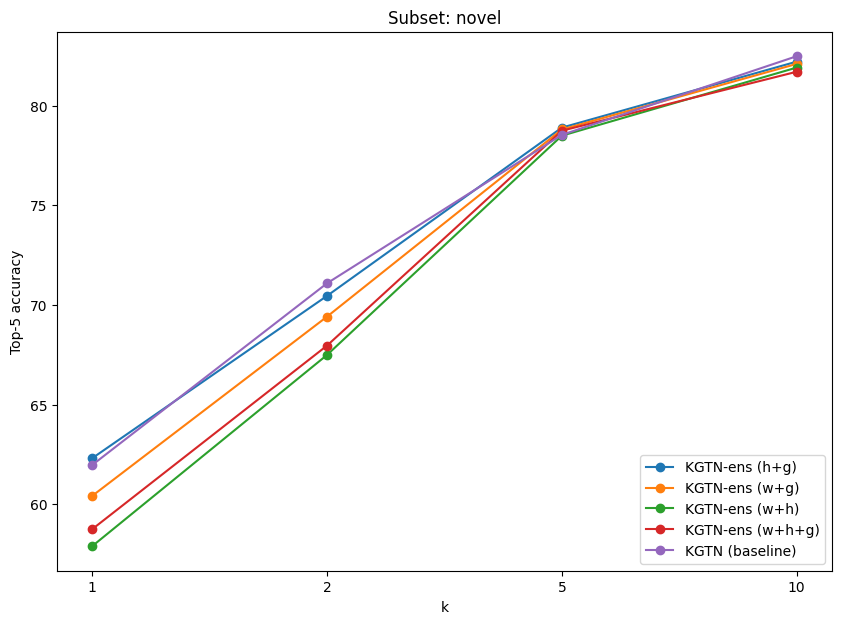

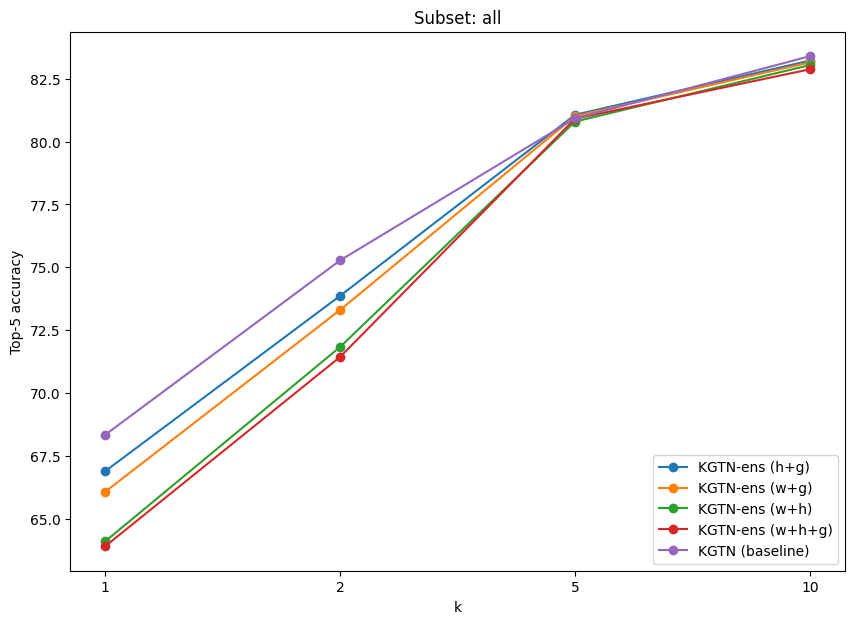

In [4]:

labels = ["1", "2", "5", "10"]

for current_type in ['novel', 'all']:
    plt.figure(figsize=(10,7))
    for x in df[df.type == current_type].iterrows():
        # print(x[1][:4].tolist())
        plt.plot(labels, x[1][:4].tolist(), marker='o', label=x[1]['label'])
        plt.legend(loc='lower right')
        plt.title(f'Subset: {current_type}')
        plt.ylabel('Top-5 accuracy')
        plt.xlabel('k')

    # plt.show()
    tikzplotlib.save(f"{FIGURES_DIR}/mean_{current_type}.tex")




# Max

In [7]:
results = []
for suffix in ['hierarchy,glove-max-InnerProduct', 'wiki,glove-max-InnerProduct', 'wiki,hierarchy-max-InnerProduct', 'wiki,hierarchy,glove-max-InnerProduct']:
    r1, r2 = parse_results(f'{PROJECT_DIR}/results/KGTNens-181121/{suffix}', 'ResNet50_sgm', 0.01, 0.0001)
    results.append(r1)
    results.append(r2)


for suffix in [
    # 'KGTN/CosSim', 
    'KGTN_InnerProduct', 
    # 'KGTN_PearCorr', 
    # 'KGTN_hierarchy'
    ]:
    r1, r2 = parse_results(f'{PROJECT_DIR}/results/{suffix}', 'ResNet50_sgm', 0.01, 0.0001)
    results.append(r1)
    results.append(r2)

# r1, r2 = parse_results(f'/tf/KGTN2/results/baseline', 'ResNet50_sgm', 0.1, 0.0001)
# results.append(r1), results.append(r2)

df = pd.DataFrame(results)
df['label'] = df['label'].apply(lambda x: x.split('/')[-1])
# df['label'] = df['label'].replace(['KGTN_InnerProduct'], 'SOTA (KGTN)')
df['label'] = df['label'].replace(['KGTN_InnerProduct'], 'KGTN (baseline)')
df['label'] = df['label'].replace(['hierarchy,glove-max-InnerProduct'], 'KGTN-ens (h+g)')
df['label'] = df['label'].replace(['wiki,glove-max-InnerProduct'], 'KGTN-ens (w+g)')
df['label'] = df['label'].replace(['wiki,hierarchy-max-InnerProduct'], 'KGTN-ens (w+h)')
df['label'] = df['label'].replace(['wiki,hierarchy,glove-max-InnerProduct'], 'KGTN-ens (w+h+g)')



print(df.filter(['type', 'label', 1, 2, 5, 10]).sort_values(['type', 'label']).to_latex(
    index=False, 
    float_format="%.2f",
    caption='Knowledge graph ensembling (max), top-5 accuracy',
    label='tab:ens-max',
    ))

\begin{table}
\centering
\caption{Knowledge graph ensembling (max), top-5 accuracy}
\label{tab:ens-max}
\begin{tabular}{llrrrr}
\toprule
 type &            label &     1 &     2 &     5 &    10 \\
\midrule
  all &  KGTN (baseline) & 68.34 & 75.27 & 80.92 & 83.40 \\
  all &   KGTN-ens (h+g) & 68.58 & 75.45 & 81.12 & 83.46 \\
  all &   KGTN-ens (w+g) & 67.69 & 75.04 & 80.95 & 83.33 \\
  all &   KGTN-ens (w+h) & 66.17 & 74.01 & 80.86 & 83.26 \\
  all & KGTN-ens (w+h+g) & 67.85 & 75.06 & 81.06 & 83.35 \\
novel &  KGTN (baseline) & 61.96 & 71.08 & 78.53 & 82.48 \\
novel &   KGTN-ens (h+g) & 62.73 & 71.48 & 78.83 & 82.56 \\
novel &   KGTN-ens (w+g) & 61.21 & 70.66 & 78.60 & 82.34 \\
novel &   KGTN-ens (w+h) & 58.77 & 69.17 & 78.44 & 82.25 \\
novel & KGTN-ens (w+h+g) & 61.32 & 70.77 & 78.70 & 82.38 \\
\bottomrule
\end{tabular}
\end{table}



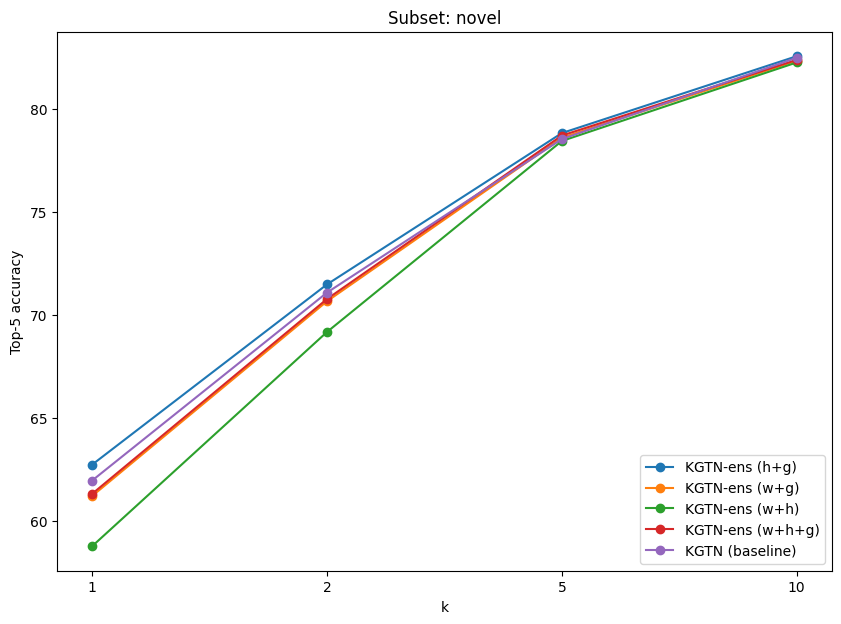

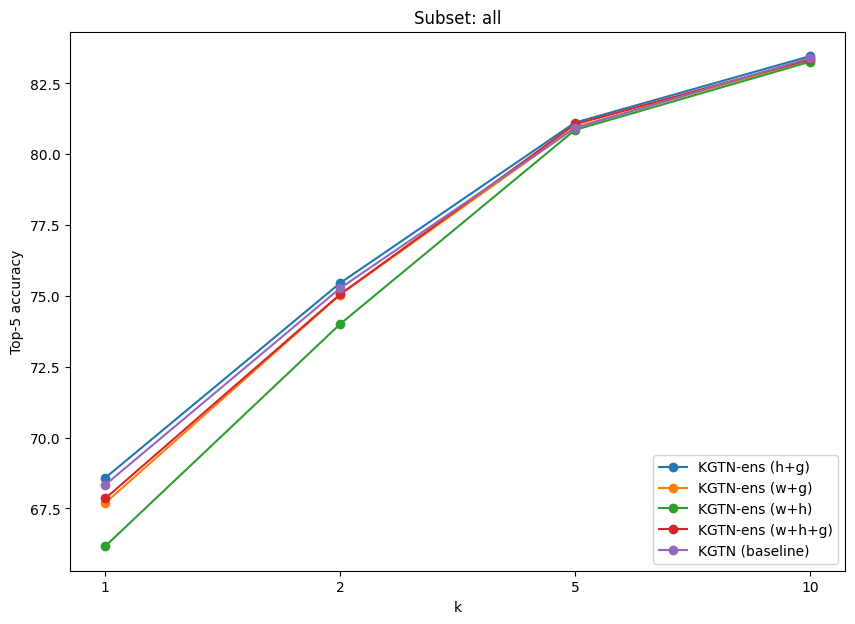

In [8]:

labels = ["1", "2", "5", "10"]

for current_type in ['novel', 'all']:
    plt.figure(figsize=(10,7))
    for x in df[df.type == current_type].iterrows():
        # print(x[1][:4].tolist())
        plt.plot(labels, x[1][:4].tolist(), marker='o', label=x[1]['label'])
        # plt.yscale('log')
        plt.legend(loc='lower right')
        plt.title(f'Subset: {current_type}')
        plt.ylabel('Top-5 accuracy')
        plt.xlabel('k')

    # plt.show()
    tikzplotlib.save(f"{FIGURES_DIR}/max_{current_type}.tex")


In [9]:
df[df['type']=='novel']

,1,2,5,10,type,label
0,62.733119,71.481672,78.825723,82.556913,novel,"hierarchy,glove-max-InnerProduct"
2,61.211576,70.662379,78.598071,82.342122,novel,"wiki,glove-max-InnerProduct"
4,58.774277,69.171704,78.442444,82.254662,novel,"wiki,hierarchy-max-InnerProduct"
6,61.317042,70.771704,78.704823,82.380707,novel,"wiki,hierarchy,glove-max-InnerProduct"
8,61.961415,71.082958,78.533762,82.482315,novel,SOTA (KGTN)


In [10]:
df[df['type']=='all']

,1,2,5,10,type,label
1,68.579882,75.454832,81.117160,83.460355,all,"hierarchy,glove-max-InnerProduct"
3,67.693886,75.044576,80.953057,83.327022,all,"wiki,glove-max-InnerProduct"
5,66.167258,74.007101,80.857594,83.263905,all,"wiki,hierarchy-max-InnerProduct"
7,67.851677,75.057988,81.056410,83.349112,all,"wiki,hierarchy,glove-max-InnerProduct"
9,68.336095,75.273373,80.923866,83.396450,all,SOTA (KGTN)


# CosSim-Max

In [21]:
results = []
for suffix in ['hierarchy,glove-max-CosSim', 'wiki,glove-max-CosSim', 'wiki,hierarchy-max-CosSim', 'wiki,hierarchy,glove-max-CosSim']:
    r1, r2 = parse_results(f'{PROJECT_DIR}/results/KGTNens-181121/{suffix}', 'ResNet50_sgm', 0.01, 0.0001)
    results.append(r1)
    results.append(r2)


for suffix in [
    # 'KGTN/CosSim', 
    'KGTN_InnerProduct', 
    # 'KGTN_PearCorr', 
    # 'KGTN_hierarchy'
    ]:
    r1, r2 = parse_results(f'{PROJECT_DIR}/results/{suffix}', 'ResNet50_sgm', 0.01, 0.0001)
    results.append(r1)
    results.append(r2)

# r1, r2 = parse_results(f'/tf/KGTN2/results/baseline', 'ResNet50_sgm', 0.1, 0.0001)
# results.append(r1), results.append(r2)

df = pd.DataFrame(results)
df['label'] = df['label'].apply(lambda x: x.split('/')[-1])
df['label'] = df['label'].replace(['KGTN_InnerProduct'], 'SOTA (KGTN)')

print(df.filter(['type', 'label', 1, 2, 5, 10]).sort_values(['type', 'label']).to_latex(
    index=False, 
    float_format="%.2f",
    caption='Knowledge graph ensembling (with cosine similarity), top-5 accuracy',
    label='tab:results_cosine',
    ))

\begin{table}
\centering
\caption{Knowledge graph ensembling (with cosine similarity), top-5 accuracy}
\label{tab:results_cosine}
\begin{tabular}{llrrrr}
\toprule
 type &                           label &     1 &     2 &     5 &    10 \\
\midrule
  all &                     SOTA (KGTN) & 68.34 & 75.27 & 80.92 & 83.40 \\
  all &      hierarchy,glove-max-CosSim & 64.86 & 73.72 & 80.05 & 83.46 \\
  all &           wiki,glove-max-CosSim & 64.43 & 73.44 & 80.01 & 83.38 \\
  all & wiki,hierarchy,glove-max-CosSim & 63.81 & 73.12 & 79.99 & 83.44 \\
  all &       wiki,hierarchy-max-CosSim & 63.87 & 73.23 & 80.00 & 83.43 \\
novel &                     SOTA (KGTN) & 61.96 & 71.08 & 78.53 & 82.48 \\
novel &      hierarchy,glove-max-CosSim & 59.57 & 69.40 & 77.29 & 81.89 \\
novel &           wiki,glove-max-CosSim & 58.34 & 68.75 & 77.24 & 81.84 \\
novel & wiki,hierarchy,glove-max-CosSim & 57.75 & 68.44 & 77.20 & 81.90 \\
novel &       wiki,hierarchy-max-CosSim & 57.35 & 68.50 & 77.27 & 81.90 \\
\bo

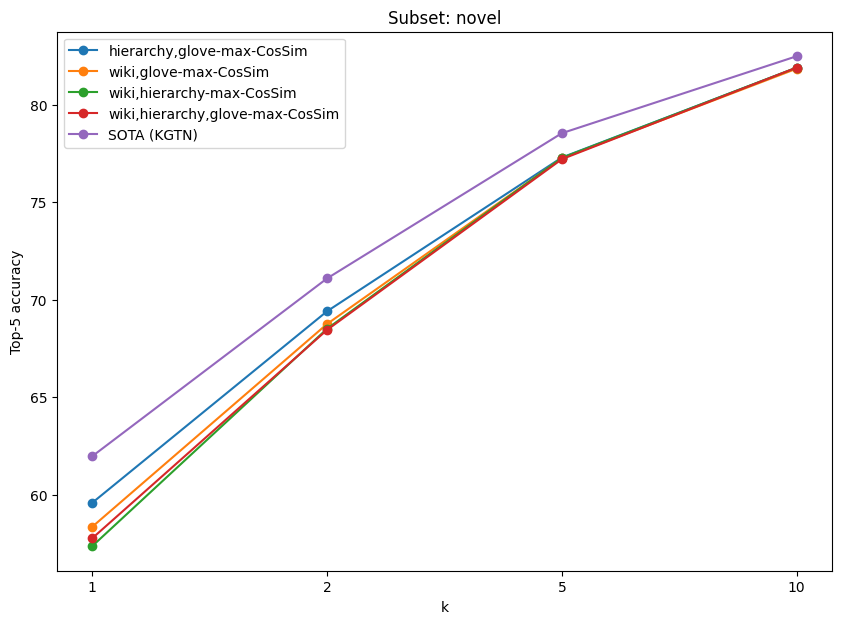

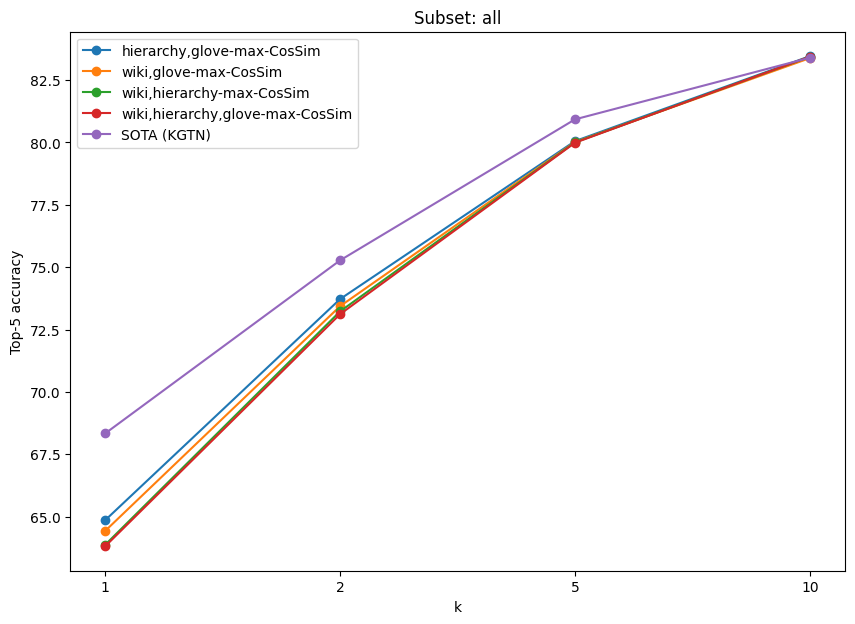

In [22]:

labels = ["1", "2", "5", "10"]

for current_type in ['novel', 'all']:
    plt.figure(figsize=(10,7))
    for x in df[df.type == current_type].iterrows():
        # print(x[1][:4].tolist())
        plt.plot(labels, x[1][:4].tolist(), marker='o', label=x[1]['label'])
        # plt.yscale('log')
        plt.legend()
        plt.title(f'Subset: {current_type}')
        plt.ylabel('Top-5 accuracy')
        plt.xlabel('k')

    # plt.show()
    tikzplotlib.save(f"{FIGURES_DIR}/max_{current_type}_cossim.tex")


In [23]:
df[df['type']=='all']

,1,2,5,10,type,label
1,64.858383,73.720710,80.051282,83.455621,all,"hierarchy,glove-max-CosSim"
3,64.429191,73.435897,80.014990,83.379093,all,"wiki,glove-max-CosSim"
5,63.872978,73.226824,80.000789,83.433531,all,"wiki,hierarchy-max-CosSim"
7,63.813018,73.115582,79.986588,83.439053,all,"wiki,hierarchy,glove-max-CosSim"
9,68.336095,75.273373,80.923866,83.396450,all,SOTA (KGTN)
